In [1]:
%autosave 180

%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
# from sklearn import metrics

Autosaving every 180 seconds


In [2]:
import numpy as np
import pandas as pd
import pylab as plt
import scipy.io as sio
from scipy.spatial.distance import cdist
from tqdm import tqdm_notebook as tqdm
import os
import sys

In [3]:
def _full_to_voigt(g):
    return np.column_stack([
        g[:, 0],
        g[:, 4],
        g[:, 8],
        g[:, 1] + g[:, 3],
        g[:, 2] + g[:, 6],
        g[:, 5] + g[:, 7],
        ])


def calculate_green_tensor(sou, rec):
    unit_vec = np.array(rec - sou, dtype=np.float32, ndmin=2)
    dist = np.sqrt((unit_vec ** 2).sum(axis=1, keepdims=True)) + 1e-15
    unit_vec /= dist
    
    gp = np.einsum('pi, pk, pl, p -> pikl', unit_vec, unit_vec, unit_vec, 1 / np.squeeze(dist))
    
    return _full_to_voigt(gp.reshape(-1, 9))

In [4]:
def signal_berlage(
        ns,
        dt,
        tau,
        f,
        alpha,
):
    tau = np.array(tau, ndmin=1, dtype=np.float32)
    
    t = np.arange(ns) * dt
    
    if np.max(tau.shape) > 1:
        t = t[None, ...]
        tau = np.array(tau, ndmin=2, dtype=np.float32)
        
    if len(tau.shape) > 1:
        if tau.shape[1] > tau.shape[0]:
            tau = tau.T
        
    t = t - tau
    alpha = alpha * ((np.pi * f) ** 2)
    spectrum = np.sin(2 * np.pi * f * t + 0)
    envelope = t * np.exp(alpha * (- t ** 2))
    
    signal = envelope * spectrum * (t > 0)
    return signal / (np.nanmax(np.abs(signal), keepdims=True, axis=-1) + 1e-15)

def forward(x):
    return np.fft.fftshift(np.fft.fft(np.fft.ifftshift(x)))

def backward(x):
    return np.real(np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(x))))

def create_bp(ns, dt, b, fit=True):
    b = np.array(b)
    nw = np.int32(np.floor(ns/2)) + 1
    b = np.int32(np.round(b*(ns-1)*dt))
    b[b < 0] = 0
    b[b > (nw-1)] = nw
    f = np.zeros(nw)
    f[b[0]: b[1]] = np.linspace(0, 1, b[1]-b[0])
    f[b[1]: b[2]] = 1
    f[b[2]: b[3]] = np.linspace(1, 0, b[3]-b[2])
    
    if fit: 
        freq = np.fft.fftfreq(ns, dt)
        freq = np.fft.fftshift(np.abs(freq) * (ns*dt)).astype(int)
        return f[freq]
    
    return f

def apply_bp_filter(x, dt, b, time_axis=1):
    if len(x.shape) == 1:
        time_axis = 0
        
    ns = x.shape[time_axis]
    x = forward(x.copy())
    return backward(x * create_bp(ns, dt, b, fit=True))

### Receivers

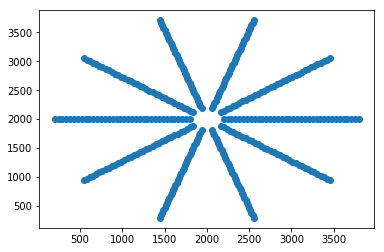

In [54]:
line = np.linspace(200, 1800, 36)
ang = np.deg2rad(np.arange(0, 360, 36))
X = line[None, ...] * np.cos(ang[...,None])
Y = line[None, ...] * np.sin(ang[...,None])
rec = np.stack([X.ravel()+2000, Y.ravel()+2000, Y.ravel()*0], axis=-1)
plt.scatter(rec[:,0], rec[:,1])

In [55]:
# [m11, m22, m33, m23, m13, m12]
moments_0 = np.array([
    [1., 1., 1., 0., 0., 0.],
    [-1., 1., 0., 0., 0., 0.],
    [ 0., 0., 0., 0., 0., 1.],
    [-0.866, 0.866, 0., -0., -0., 0.5],
    [2.635,  5.367,  3., 0., 0., -0.366]
])

sources_0 = np.array([
    [1750, 1750, 2000],
    [2250, 1750, 2000],
    [1750, 2250, 2000],
    [2250, 2250, 2000],
    [2000, 2000, 2000],
])


tau_0 = np.array([0.1, 0.275, 0.45, 0.625, 0.8])
freq_0 = np.array([35, 35, 50, 40, 45])
alpha_0 = np.array([.5, .5, .3, .25, .4])
amplitude_0 = np.array([1, 1, 1, 1, 1])

# Generate Isotropic Syntetic

In [82]:
vp = 3500
dt = .001
ns = 1024

distance = cdist(sources_0, rec)
time_0 = distance / vp
time_0 -= time_0.min(axis=1, keepdims=True)


traces = np.zeros((len(rec), ns))
for i in range(5):
    gp = calculate_green_tensor(sources_0[i], rec)
    amplitude = gp.dot(moments_0[i])[2::3]
    amplitude /= np.nanmax(np.abs(amplitude) + 1e-15)
    tmp = signal_berlage(ns, dt, time_0[i] + tau_0[i]*ns*dt, freq_0[i], alpha_0[i])
    traces += tmp * amplitude_0[i] * amplitude[..., None]

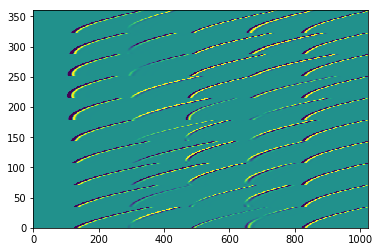

In [83]:
plt.pcolormesh(traces, vmin=-.3, vmax=.3)

# Inversion

In [84]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.gridspec as gridspec

def plot_semblance(stacks, t, w2d, nx, ny, tau_0):
    
    fig = plt.figure(constrained_layout=True, figsize=(6, 6))
    gs = gridspec.GridSpec(nrows=4, ncols=1, figure=fig)
    

    stacks = np.abs(stacks.copy())

    ns = stacks.shape[0]
    semblance = stacks[t,:]
    idx = np.abs(semblance).argmax()

#         out = dsp.moving_average_1d(out,window, axis=0)
    summa = np.abs(stacks).max(axis=1)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1:, 0])

    ax1.plot(np.arange(ns), summa)
    ax1.scatter(tau_0, summa[tau_0])
    ax1.plot(np.arange(ns), np.abs(stacks)[:,idx])
    ax1.plot(np.array([t, t]), summa.max() * np.array([0,1]))
    ax1.set_xlim([0, ns])

    semblance = semblance.reshape(nx, ny)
#     semblance = convolve(semblance, np.ones((w2d, w2d)), mode='same')
    ax2.imshow(
        np.abs(semblance.T), 
        origin='upper',
        cmap='seismic'
    )

# Summation without inversion

In [85]:
nx = 50
ny = 50
[sx, sy] = np.meshgrid(
    np.linspace(1500, 2500, nx),
    np.linspace(1500, 2500, ny)
)
sources = np.stack([sx, sy, sy*0 + 2000], axis=-1)
sources = sources.reshape(-1, 3)
# sources = sources_0

times = cdist(sources, rec) / vp
times -= times.min(axis=1, keepdims=True)
times = np.round(times / dt).astype(int)

r_range = np.arange(traces.shape[0])
t_range = np.arange(traces.shape[1])

raw_traces = np.column_stack([traces, np.zeros((traces.shape[0], times.max() + 2))])

stacks = np.zeros((times.shape[0], traces.shape[1]))

for i, cur_sou  in enumerate(tqdm(sources)):
    idx_time = times[i][None,...] + t_range[..., None]

    cur_traces = raw_traces[r_range, idx_time]
    stacks[i] = cur_traces.sum(axis=1)

# unfocused events

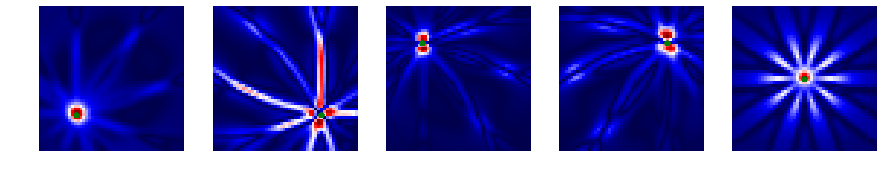

In [86]:
i_tau_0 = np.round(tau_0 * traces.shape[1]).astype(int) + 10
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
axs = axs.ravel()
for i in range(5):
    axs[i].imshow(
        np.abs(stacks)[:, i_tau_0[i]].reshape(nx, ny), 
        cmap='seismic',
        origin='lower',
        extent=(sources[:,0].min(), sources[:,0].max(), sources[:,1].min(), sources[:,1].max())
    )
    axs[i].plot(*sources_0[i,:2], 'pg')
    axs[i].set_axis_off()

In [87]:
interact(
    plot_semblance, 
    stacks=fixed(stacks.T),
    nx=fixed(nx), 
    ny=fixed(ny),
    tau_0=fixed(i_tau_0),
    t=widgets.IntSlider(min=0,max=stacks.shape[1],step=1, value=10, continuous_update=False),
    w2d=widgets.IntSlider(min=1,max=50,step=1, value=1, continuous_update=False),
);

interactive(children=(IntSlider(value=10, continuous_update=False, description='t', max=1024), IntSlider(value…

# Perform Summation with Inversion

# Init scan area

In [88]:
def inverse_operator(x, lam=0):
    e = lam * np.eye(6, 6)
    e[0, 0] = 0
    return np.linalg.pinv(x.T.dot(x) + e)


def moment_inversion(x, d, lam=0):
    xi = inverse_operator(x, lam=lam)
    return xi.dot(x.T).dot(d)


def get_weight(x, only_sign=True):
    if only_sign:
        return (x < 0) * (-1.) + (x >= 0)
    return 1 / (x + 1e-11*np.sign(x))

In [90]:
nx = 40
ny = 40
[sx, sy] = np.meshgrid(
    np.linspace(1500, 2500, nx),
    np.linspace(1500, 2500, ny)
)
sources = np.stack([sx, sy, sy*0 + 2000], axis=-1)
sources = sources.reshape(-1, 3)
# sources = np.array([[2000,2000,2000]])

times = cdist(sources, rec) / vp
times -= times.min(axis=1, keepdims=True)
times = np.round(times / dt).astype(int)

window = 100
slide = 1

r_range = np.arange(traces.shape[0])
t_range = np.arange(traces.shape[1])

i_range = np.arange(window)[..., None] + np.arange(0, traces.shape[1] - window, slide)[None, ...]
raw_traces = np.column_stack([traces, np.zeros((traces.shape[0], times.max() + 1))])


# Add noise and apply band-pass filter

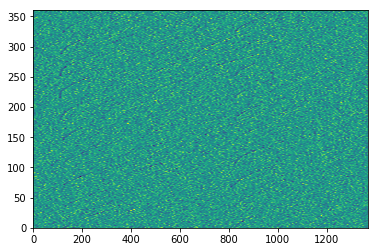

In [91]:
raw_traces += np.random.randn(*raw_traces.shape) * 1
raw_traces = apply_bp_filter(raw_traces, dt, [0,5,60,100])
plt.pcolormesh(raw_traces)

In [118]:
stack.shape

(100, 924, 360)

In [132]:
stack.shape

(100, 924, 360)

In [133]:
stacks_conv = np.zeros((times.shape[0], window, i_range.shape[1]))
stacks = np.zeros((times.shape[0], window, i_range.shape[1]))
sigmas = np.zeros((times.shape[0], i_range.shape[1], 6))
moments = np.zeros((times.shape[0], i_range.shape[1], 6))

for i, cur_sou  in enumerate(tqdm(sources)):
   
    cur_time = times[i]

    idx_time = cur_time[None,...] + t_range[..., None]

    cur_traces = raw_traces[r_range, idx_time]
    
    cur_d = cur_traces.reshape(cur_traces.shape[0], -1).T
    cur_gp = calculate_green_tensor(cur_sou, rec)
    cur_gp = cur_gp[2::3]
    

    mi = moment_inversion(cur_gp, cur_d)
    mi = mi[:, i_range]
    mi = np.transpose(mi, axes=(2, 1, 0))
    
    w, s, v = np.linalg.svd(mi)
    
    wavelet = np.fft.ifftshift(w[:, :, 0], axes=1)
    moment = v[:, 0, :]
    moments[i] = moment
    sigmas[i] = s
    
    weight = cur_gp.dot(moment.T).T
    weight = get_weight(weight) * (s[:,0] / s[:,1])[:, None]
    
    stack = cur_traces[i_range] * weight[None,...] 
    stacks[i] = np.abs(stack.mean(axis=2))
    
    stack_conv = np.fft.fft(stack, axis=0) * np.conjugate(np.fft.fft(wavelet.T[..., None], axis=0))
    stack_conv = np.real(np.fft.ifft(stack_conv, axis=0))

    stacks_conv[i] = np.abs(stack_conv.mean(axis=2))
    

# Event stacks at Tau0

In [135]:
stacks.shape

(1600, 100, 924)

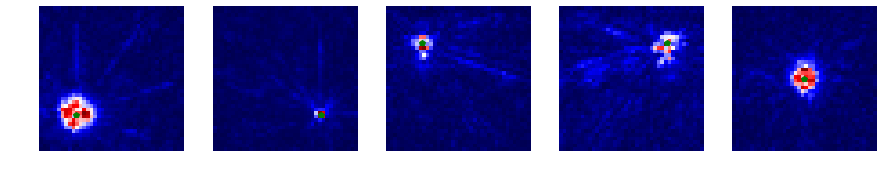

In [138]:
i_tau_0 = np.round(tau_0 * traces.shape[1]).astype(int) + 5
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
axs = axs.ravel()
for i in range(5):
    axs[i].imshow(
        np.abs(stacks)[:, :, i_tau_0[i]].max(axis=1).reshape(nx, ny), 
        cmap='seismic',
        origin='lower',
        extent=(sources[:,0].min(), sources[:,0].max(), sources[:,1].min(), sources[:,1].max())
    )
    axs[i].plot(*sources_0[i,:2], 'pg')
    axs[i].set_axis_off()

# Event Sigmas at Tau0

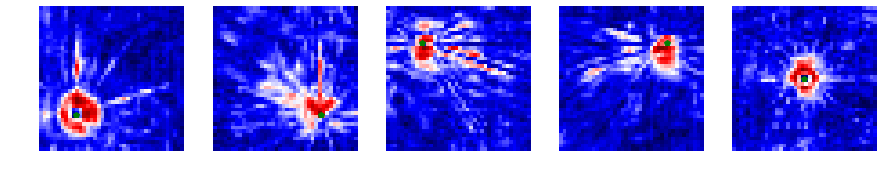

In [127]:
i_tau_0 = np.round(tau_0 * traces.shape[1]).astype(int) + 10
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
axs = axs.ravel()
for i in range(5):
    axs[i].imshow(
        np.abs(sigmas)[:, i_tau_0[i], 0].reshape(nx, ny), 
        cmap='seismic',
        origin='lower',
        extent=(sources[:,0].min(), sources[:,0].max(), sources[:,1].min(), sources[:,1].max())
    )
    axs[i].plot(*sources_0[i,:2], 'pg')
    axs[i].set_axis_off()

# Event Sigmas 2 at Tau0

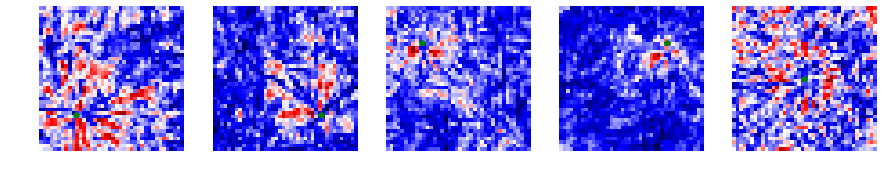

In [128]:
i_tau_0 = np.round(tau_0 * traces.shape[1]).astype(int) + 10
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
axs = axs.ravel()
for i in range(5):
    axs[i].imshow(
        np.abs(sigmas)[:, i_tau_0[i], 1].reshape(nx, ny), 
        cmap='seismic',
        origin='lower',
        extent=(sources[:,0].min(), sources[:,0].max(), sources[:,1].min(), sources[:,1].max())
    )
    axs[i].plot(*sources_0[i,:2], 'pg')
    axs[i].set_axis_off()

# Event Sigmas 3 at Tau0

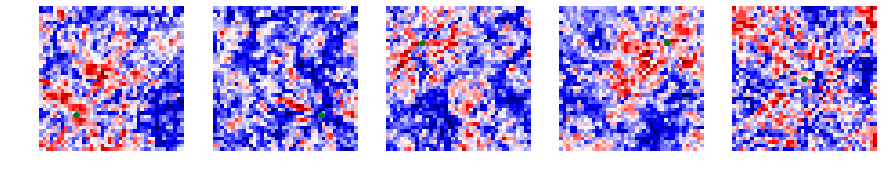

In [129]:
i_tau_0 = np.round(tau_0 * traces.shape[1]).astype(int) + 10
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
axs = axs.ravel()
for i in range(5):
    axs[i].imshow(
        np.abs(sigmas)[:, i_tau_0[i], 2].reshape(nx, ny), 
        cmap='seismic',
        origin='lower',
        extent=(sources[:,0].min(), sources[:,0].max(), sources[:,1].min(), sources[:,1].max())
    )
    axs[i].plot(*sources_0[i,:2], 'pg')
    axs[i].set_axis_off()

In [139]:
stacks.shape

(1600, 100, 924)

In [141]:
interact(
    plot_semblance, 
    stacks=fixed(stacks.max(axis=1).T),
    nx=fixed(nx), 
    ny=fixed(ny),
    t=widgets.IntSlider(min=0,max=stacks.shape[-1],step=1, value=10, continuous_update=False),
    w2d=widgets.IntSlider(min=1,max=50,step=1, value=1, continuous_update=False),
    tau_0=fixed(i_tau_0),
);

interactive(children=(IntSlider(value=10, continuous_update=False, description='t', max=924), IntSlider(value=…

In [111]:
interact(
    plot_semblance, 
    stacks=fixed((sigmas[...,0] / sigmas[...,1]).T),
    nx=fixed(nx), 
    ny=fixed(ny),
    t=widgets.IntSlider(min=0,max=stacks.shape[1],step=1, value=10, continuous_update=False),
    w2d=widgets.IntSlider(min=1,max=50,step=1, value=1, continuous_update=False),
    tau_0=fixed(i_tau_0),
);

interactive(children=(IntSlider(value=10, continuous_update=False, description='t', max=924), IntSlider(value=…

In [75]:
def focal_projection(m, n=40, return_grid=False):

    x = np.linspace(-1, 1, n)[None, ...]
    y = np.linspace(-1, 1, n)[..., None]

    x2 = x.repeat(n, axis=0)
    y2 = y.repeat(n, axis=1)

    r2 = x2 * x2 + y2 * y2
    trend = np.arctan2(y2, x2)
    plunge = np.pi / 2 - 2 * np.arcsin(np.sqrt(r2 / 2))  # equal area projection

    vij1 = np.cos(trend) * np.cos(plunge)  # set up local vector grids
    vij2 = np.sin(trend) * np.cos(plunge)
    vij3 = np.sin(plunge)

    m = np.array(m)
    if len(m.ravel()) == 9:
        m = moment_convert(m)

    u1 = (vij1 * m[0] + vij2 * m[5] + vij3 * m[4]) * vij1
    u2 = (vij1 * m[5] + vij2 * m[1] + vij3 * m[3]) * vij2
    u3 = (vij1 * m[4] + vij2 * m[3] + vij3 * m[2]) * vij3
    u = u1 + u2 + u3
    u[r2 > 1] = np.nan

    return u

In [76]:
dx = np.linspace(1500, 2500, nx)
dx = dx[1] - dx[0]

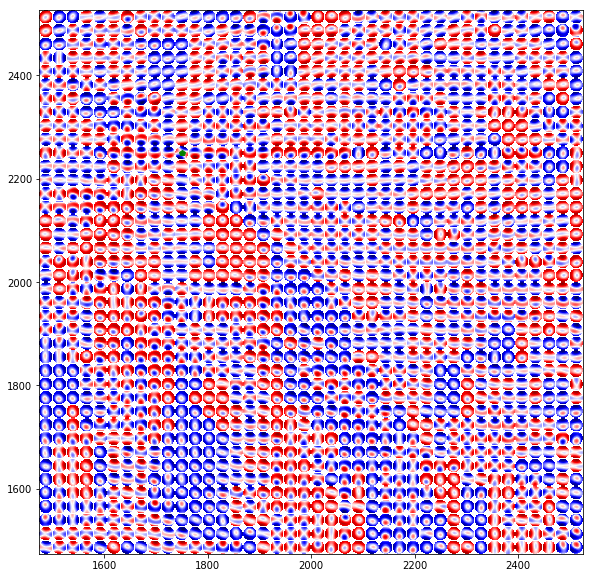

In [144]:
ie = 2
u = np.zeros((40*nx, 40*ny))
i = 0
tmp0 = focal_projection(moments_0[ie])
for ix in range(nx):
    for iy in range(nx):
        xfrom = ix * 40
        xtill = (ix + 1) * 40
        yfrom = iy * 40
        ytill = (iy + 1) * 40
        tmp = focal_projection(moments[i,i_tau_0[ie]])
#         tmp = (tmp0 - tmp)**2
#         tmp = tmp / np.nanmax(tmp)
        u[xfrom:xtill, yfrom:ytill] = tmp# * (sigmas[i,i_tau_0[ie],0])
        i+=1

plt.figure(figsize=(10,10))
plt.imshow(
    u, 
    cmap='seismic',
    origin='lower',
    extent=(sources[:,0].min()-dx, sources[:,0].max()+dx, sources[:,1].min()-dx, sources[:,1].max()+dx)
)
plt.plot(*sources_0[ie,:2], 'pg')

In [78]:
alphas = sigmas[...,0] / np.nanmax(sigmas[...,0], axis=1, keepdims=True)

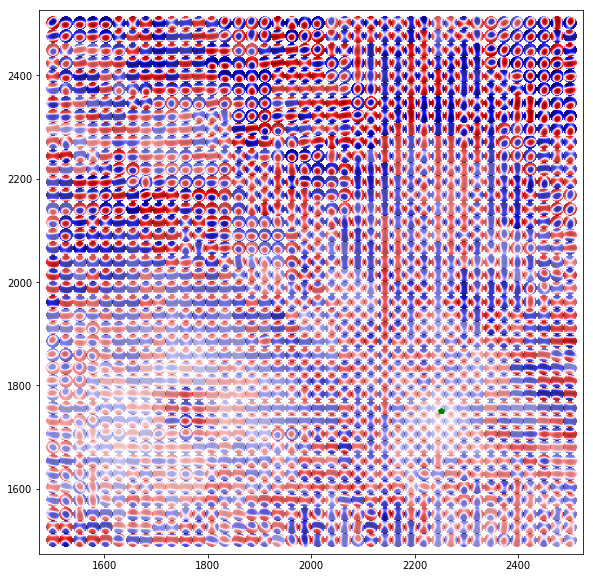

In [143]:
ie = 1
i = 0
plt.figure(figsize=(10,10))
tmp0 = focal_projection(moments_0[ie])
for ix in range(nx):
    for iy in range(nx):
        xfrom = ix * 40
        xtill = (ix + 1) * 40
        yfrom = iy * 40
        ytill = (iy + 1) * 40
        tmp = focal_projection(moments[i,i_tau_0[ie]-20])
        
        cur_src = sources[i]
        extent = (cur_src[0] - dx/2, cur_src[0] + dx/2, cur_src[1] - dx/2, cur_src[1] + dx/2)
        plt.imshow(
            tmp, 
            cmap='seismic',
            origin='lower',
            extent=extent,
            alpha=alphas[i,i_tau_0[ie]],
        )
        i+=1
        
plt.plot(*sources_0[ie,:2], 'pg')
plt.xlim((sources[:,0].min()-dx, sources[:,0].max()+dx));
plt.ylim((sources[:,1].min()-dx, sources[:,1].max()+dx));

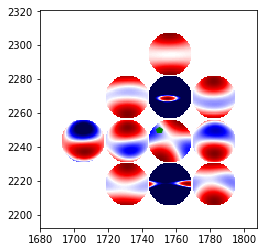

In [204]:
ie = 2
idx_distance = cdist(sources, sources_0[[ie]])[:,0].argsort()

_tmp_src = []
for i in idx_distance[:11]:
    tmp = focal_projection(moments[i,i_tau_0[ie]-20])
    tmp = tmp/np.nanmax(tmp)
    cur_src = sources[i]
    extent = (cur_src[0] - dx/2, cur_src[0] + dx/2, cur_src[1] - dx/2, cur_src[1] + dx/2)
    _tmp_src.append(cur_src)
    plt.imshow(
        tmp, 
        cmap='seismic',
        origin='lower',
        extent=extent,
#         alpha=alphas[i,i_tau_0[ie]],
        vmin=-1.01,
        vmax=1.01,
    )
_tmp_src = np.array(_tmp_src)
plt.plot(*sources_0[ie,:2], 'pg')
plt.xlim((_tmp_src[:,0].min()-dx, _tmp_src[:,0].max()+dx));
plt.ylim((_tmp_src[:,1].min()-dx, _tmp_src[:,1].max()+dx));

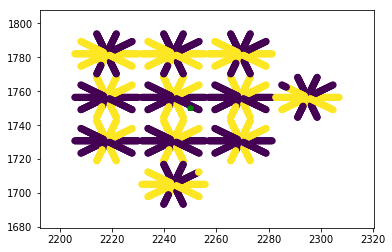

In [205]:
_recs = rec[:, :2]/np.max(np.abs(rec[:, :2]), axis=0, keepdims=True)
_recs -= _recs.mean(axis=0, keepdims=True)

ie = 1
idx_distance = cdist(sources, sources_0[[ie]])[:,0].argsort()

_tmp_src = []
for i in idx_distance[:11]:
    cur_src = sources[i]
    _tmp_src.append(cur_src)
    
    tmp = moments[i,i_tau_0[ie]-30]
    cur_gp = calculate_green_tensor(cur_src, rec)
    
    cur_gp = cur_gp[2::3]
    weight = cur_gp.dot(tmp).T
    weight = get_weight(weight)
    
    plt.scatter(_recs[:,0]*dx+cur_src[0], _recs[:,1]*dx+cur_src[1], c=weight)
_tmp_src = np.array(_tmp_src)
plt.plot(*sources_0[ie,:2], 'pg')
plt.xlim((_tmp_src[:,0].min()-dx, _tmp_src[:,0].max()+dx));
plt.ylim((_tmp_src[:,1].min()-dx, _tmp_src[:,1].max()+dx));